In [1]:
import os
os.chdir('../')

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datetime import datetime
from torchvision import transforms

from art.attacks.evasion import FastGradientMethod, CarliniL2Method, AutoAttack
from art.estimators.classification import PyTorchClassifier

import utils
import model

## Constants

In [3]:
dataset = 'CIFAR10'
model1 = 'densenet121'
path1 = '/home/giorgioseveri/projects/advml/lemon/cifar10_models/state_dicts/densenet121.pt'

## Data

In [4]:
trainset = utils.load_dataset(dataset, True, download=True)
testset = utils.load_dataset(dataset, False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(testset.transform)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [6]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [7]:
tst_ld = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

In [8]:
tst_imgs, tst_lbs = None, None
for batch in tst_ld:
    tst_imgs, tst_lbs = batch
    break
print(tst_imgs.shape)
print(tst_lbs.shape)

torch.Size([8, 3, 32, 32])
torch.Size([8])


## Model

In [9]:
architecture_1 = eval(f"model.{model1}")
print(architecture_1)
net = architecture_1()
net.load_state_dict(torch.load(path1))
net = net.eval()

<function densenet121 at 0x7f74789fc280>


In [10]:
tst_imgs_preds_raw = net(tst_imgs)
tst_imgs_preds = torch.argmax(tst_imgs_preds_raw, dim=1)
print('Original labels:', tst_imgs_preds)
print('Predicted labels:', tst_lbs)
print(tst_imgs_preds == tst_lbs)

Original labels: tensor([3, 8, 8, 0, 6, 6, 1, 6])
Predicted labels: tensor([3, 8, 8, 0, 6, 6, 1, 6])
tensor([True, True, True, True, True, True, True, True])


## ART

In [11]:
criterion = torch.nn.CrossEntropyLoss()
classifier = PyTorchClassifier(
    model=net,
    loss=criterion,
    clip_values=(torch.min(tst_imgs), torch.max(tst_imgs)),
    input_shape=tst_imgs.shape[1:],
    nb_classes=10,
)

In [12]:
art_preds = classifier.predict(tst_imgs)
assert np.allclose(art_preds, tst_imgs_preds_raw.detach().numpy())

In [14]:
# attack = FastGradientMethod(estimator=classifier, eps=0.2)
attack = CarliniL2Method(classifier=classifier )


In [15]:
x_test_adv = attack.generate(x=tst_imgs.numpy())

C&W L_2:   0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
x_test_adv_preds_raw = classifier.predict(x_test_adv)
x_test_adv_preds = np.argmax(x_test_adv_preds_raw, axis=1)
print('Original predicted labels:', tst_imgs_preds)
print('New predicted labels:', x_test_adv_preds)
print('Attack success rate', 1 - np.mean(x_test_adv_preds == tst_imgs_preds.numpy()))

Original predicted labels: tensor([3, 8, 8, 0, 6, 6, 1, 6])
New predicted labels: [5 1 1 9 4 5 1 2]
Attack success rate 0.875


Original image before and after normalization


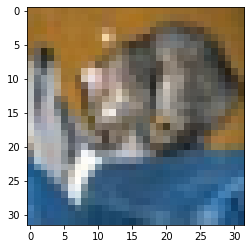

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


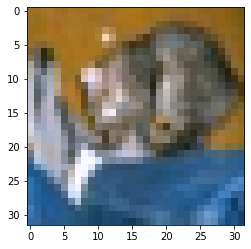

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original label: tensor(3)

Adversarial image:


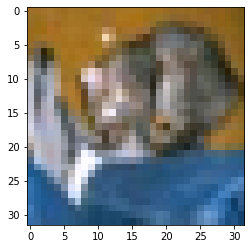

Adversarial label: 5


In [17]:
print('Original image before and after normalization')
plt.imshow(testset.data[0])
plt.show()
imshow(tst_imgs[0])
plt.show()
print('Original label:', tst_lbs[0])

print('\nAdversarial image:')
imshow(torch.tensor(x_test_adv[0]))
plt.show()
print('Adversarial label:', x_test_adv_preds[0])

In [30]:
base_res_path = 'images'
exp_path = os.path.join(base_res_path, 'victim_{}_{}'.format(model1, dataset))
orig_path = os.path.join(exp_path, 'orig')
adv_path = os.path.join(exp_path, 'adv')

os.makedirs(base_res_path, exist_ok=True)
os.makedirs(exp_path, exist_ok=True)
os.makedirs(orig_path, exist_ok=True)
os.makedirs(adv_path, exist_ok=True)

In [31]:
ts = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print(ts)

2022-04-30_23-22-42


In [44]:
orig_file = os.path.join(orig_path, 'test_{}_{}.npy'.format(tst_imgs.shape[0], ts))
adv_file = os.path.join(adv_path, 'test_{}_{}.npy'.format(tst_imgs.shape[0], ts))

np.save(orig_file, tst_imgs.numpy())
np.save(adv_file, x_test_adv)